In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [5]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'retina'"""

import warnings

from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import pickle

from scipy.optimize import curve_fit

import statsmodels.formula.api as smf

from neurodsp.spectral import compute_spectrum
from fooof import FOOOF

""" import seaborn as sns
sns.set_style('whitegrid')"""

import matplotlib.pyplot as plt
#from matplotlib import cm, rc



### Read pickle files  - rat single knee results after removing outliers 

In [7]:
#loop through pickle results in folder

pickle_dir_taus = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_timescales.pickle'
pickle_dir_divs  = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_divs.pickle'


In [9]:
#load pickle files
with open(pickle_dir_taus, 'rb') as f:
    rat_taus = pickle.load(f)
    
with open(pickle_dir_divs, 'rb') as f:
    rat_divs = pickle.load(f)

Text(0.5, 0, 'DIVS')

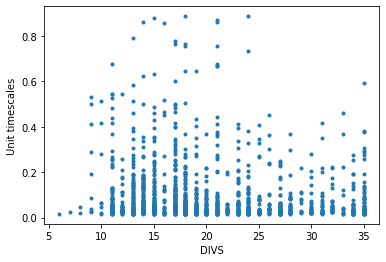

In [15]:
plt.plot(rat_divs, rat_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

##### It looks like the early divs have very few timepoints after outlier removal

In [70]:

# Assuming you have 'divs' as your numpy array
unique_divs, divs_counts = np.unique(rat_divs, return_counts=True)

# Now, 'unique_divs' contains unique values in 'divs', and 'divs_counts' contains their respective counts
for div, count in zip(unique_divs, divs_counts):
    print(f"div: {div}, Count: {count}")

div: 6, Count: 1
div: 7, Count: 1
div: 8, Count: 2
div: 9, Count: 9
div: 10, Count: 8
div: 11, Count: 77
div: 12, Count: 29
div: 13, Count: 83
div: 14, Count: 100
div: 15, Count: 112
div: 16, Count: 29
div: 17, Count: 130
div: 18, Count: 128
div: 19, Count: 59
div: 20, Count: 43
div: 21, Count: 68
div: 22, Count: 17
div: 23, Count: 50
div: 24, Count: 64
div: 25, Count: 30
div: 26, Count: 25
div: 27, Count: 45
div: 28, Count: 28
div: 29, Count: 10
div: 30, Count: 24
div: 31, Count: 25
div: 32, Count: 23
div: 33, Count: 12
div: 34, Count: 41
div: 35, Count: 62


#### Remove divs before DIV 11 - not enough datapoints

In [154]:

# Assuming you have 'divs' and 'taus' as your numpy arrays
threshold = 11  # Set your desired threshold value

# Create a mask to filter data points where divs are greater than or equal to the threshold
mask = (rat_divs >= threshold)

# Apply the mask to both 'divs' and 'taus' arrays
filtered_divs = rat_divs[mask]
filtered_taus = rat_taus[mask]

Text(0.5, 0, 'DIVS')

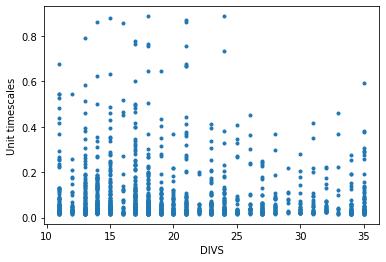

In [155]:
plt.plot(filtered_divs, filtered_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

## Hypotheses fitting (for figure 2 for timescale dev paper)

In [156]:
def rsq(xdata, ydata, popt, f):
    
    #residual sum of squares
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared
    

In [157]:
def f_test(xdata, ydata, model0, model1, popt0, popt1, p0, p1):

    yfit0 = model0(xdata, *popt0)
    yfit1 = model1(xdata, *popt1)

    ssq0 = ((yfit0-ydata)**2).sum()
    ssq1 = ((yfit1-ydata)**2).sum()
    
    param_diff = p1 - p0
    
    if param_diff == 0:
        df_0 = len(xdata) - p0
        df_1 = len(xdata) - p1
        f_ratio = ssq1/ssq0
        p = 1 - ss.f.cdf(f_ratio, df_0, df_1)
    else:
        df = len(xdata) - p1
        f_ratio = ((ssq0 - ssq1) / param_diff) / (ssq1 / df)
        p = 1 - ss.f.cdf(f_ratio, param_diff, df)

    return f_ratio, p

In [193]:
# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define the sigmoid function
def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-C * (x - B))) + D

# Define the horizontal line function (constant)
def horizontal_line(x, A):
    return A

In [197]:
def fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid):
    
    # Fit the Gaussian function to your data
    params_gaussian, _ = curve_fit(gaussian, divs, taus, p0=guess_gaussian, bounds=bounds_gaussian, maxfev=800)

    # Fit the sigmoid function to your data
    params_sigmoid, _ = curve_fit(sigmoid, divs, taus, p0=guess_sigmoid, maxfev=800)

    # Fit the horizontal line to your data
    params_horizontal_line, _ = curve_fit(horizontal_line, divs, taus)


    # Create a range of x values for plotting
    x_fit = np.linspace(min(divs), max(divs), 100)

    # Calculate the corresponding y values using the fitted parameters for each function
    y_fit_gaussian = gaussian(x_fit, *params_gaussian)
    y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
    y_fit_horizontal_line = horizontal_line(x_fit, params_horizontal_line[0])

    # Plot the data and the fitted functions
    plt.figure(figsize =  (6,5))
    # Create the scatter plot of the data
    plt.plot(divs, taus, '.', color = "dimgrey")
    #plt.ylabel("Log(timescales)", size = 18)
    #plt.xlabel("Days ", size = 18)
    plt.xticks(size = 13)
    plt.yticks(size = 13)

    plt.plot(x_fit, y_fit_gaussian, '-.',color='#B22222', linewidth=5, dashes=(2, 2))
    plt.plot(x_fit, y_fit_sigmoid, '-.', color='darkgreen', linewidth=5, dashes=(1, 2))
    plt.axhline(y=params_horizontal_line[0], color='#FFC125', linestyle='-.', linewidth=5,dashes=(2,2))

    plt.show()


### Linear version

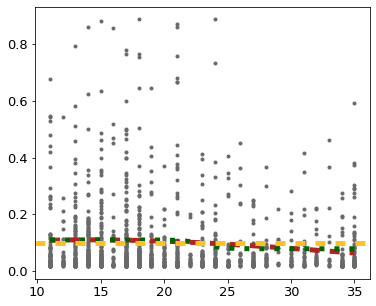

In [198]:


# Guess and bounds for Gaussian fit
guess_gaussian = [0.4, 12, 5]
bounds_gaussian = ([0, 12, 5], [10, max(filtered_divs), 20])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (1.0, 15.0, 1.0, 1.0)
bounds_sigmoid = ([0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, max(filtered_taus)])

fit_hyp(filtered_divs, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)


### Logged version

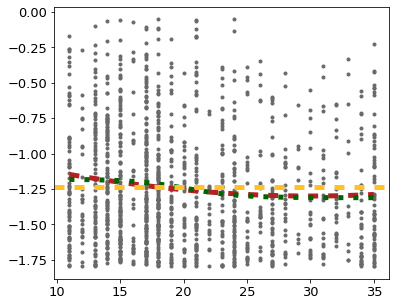

In [204]:
filtered_taus_log = np.log10(filtered_taus)

# Guess and bounds for Gaussian fit
guess_gaussian = [0, 15, 5]
bounds_gaussian = ([-1.50, 12, -np.inf], [np.inf,30, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 25.0, 1.0, 1.0)
bounds_sigmoid = ([0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, max(filtered_taus_log)])

fit_hyp(filtered_divs, filtered_taus_log, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)


### Normalized divs linear 

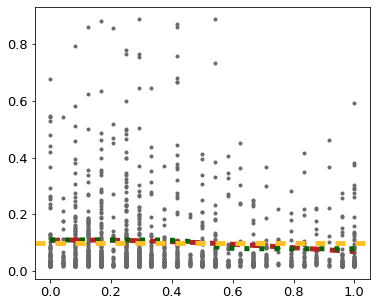

In [221]:

# Normalize the divs data to the range [0, 1]
divs_normalized = (divs - divs.min()) / (divs.max() - divs.min())

# Guess and bounds for Gaussian fit
guess_gaussian = [0, 0.2, 5]
bounds_gaussian = ([-1.50, 0.1, -np.inf], [np.inf,0.4, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 0.2, 1.0, 1.0)
bounds_sigmoid = ([0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, max(filtered_taus_log)])


fit_hyp(divs_normalized, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)


### Normalized divs logged

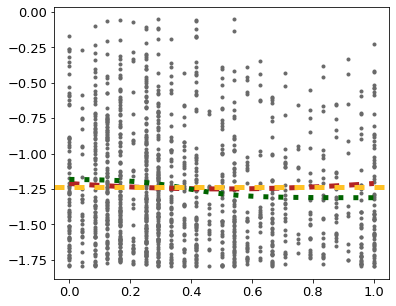

In [224]:

# Normalize the divs data to the range [0, 1]
divs_normalized = (divs - divs.min()) / (divs.max() - divs.min())

# Guess and bounds for Gaussian fit
guess_gaussian = [0, 0.2, 2]
bounds_gaussian = ([-1.25, 0.1, -.2], [np.inf,0.5, 2])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 0.2, 1.0, 1.0)
bounds_sigmoid = ([0, -np.inf, 0, 0], [np.inf, np.inf, np.inf, max(filtered_taus_log)])


fit_hyp(divs_normalized, filtered_taus_log, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)


In [ ]:
#get r-squared values

rsqs_rat_h0 = rsq(days, mean_taus, model_params_mean[0], h_line) 
rsqs_rat_h1 = rsq(days, mean_taus, model_params_mean[1], sig_func) 
rsqs_rat_h2 = rsq(days, mean_taus, model_params_mean[2], gaus) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

In [ ]:
#f-tests
f_test_h0_h1 = f_test(days, mean_taus, h_line, sig_func,
                      model_params_mean[0], model_params_mean[1], 1, 4)
f_test_h0_h2 = f_test(days, mean_taus, h_line, gaus, 
                      model_params_mean[0], model_params_mean[2],1,4)
f_test_h2_h1 = f_test(days, mean_taus, gaus, sig_func, 
                      model_params_mean[2], model_params_mean[1],4,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)